<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/Pink%20Noise%20Decoupling%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [4]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

In [5]:
import multiprocessing
from multiprocessing import cpu_count
from multiprocessing import Pool, Manager
from functools import partial

import threading

manager = Manager()
multiprocessing_dict = manager.dict()
pool = multiprocessing.Pool(processes = cpu_count())

cpu_count()

8

In [6]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

### 1) Single $ \pi $ Envelope

In [3]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

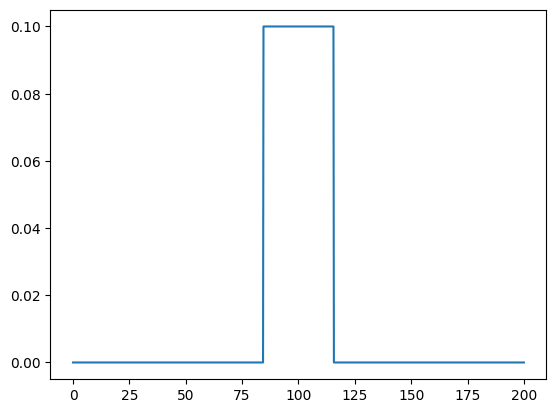

In [4]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Square(tlist, {'A': 0.1}, 100))

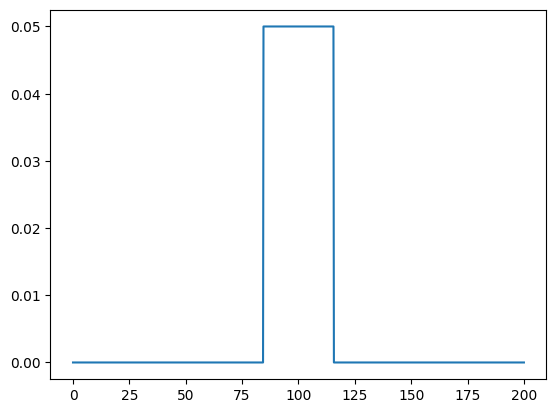

In [5]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Square(tlist, {'A': 0.1}, 100))

In [6]:
# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

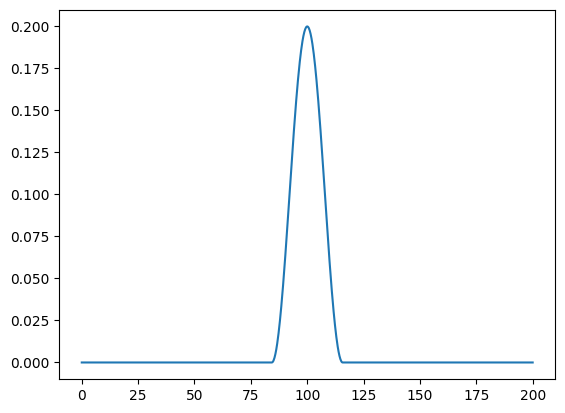

In [7]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Cosine(tlist, {'A': 0.1}, 100))

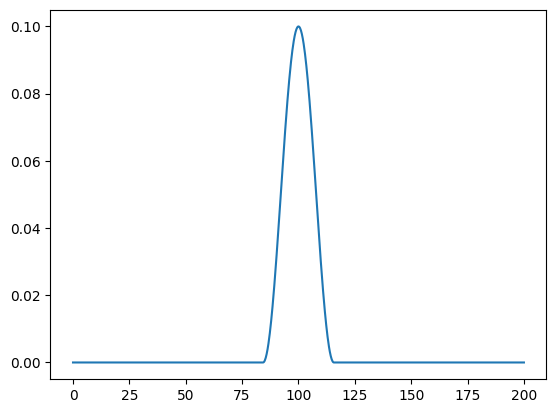

In [8]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Cosine(tlist, {'A': 0.1}, 100))

In [9]:
# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

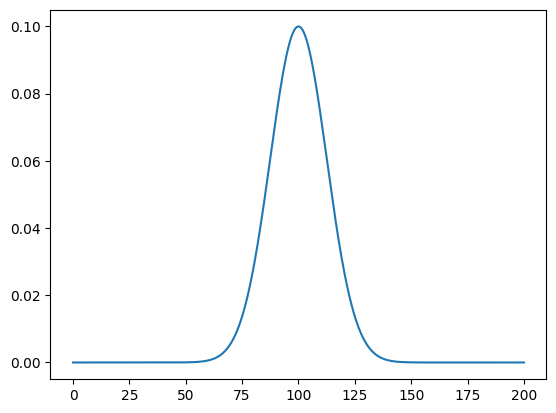

In [10]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Gaussian(tlist, {'A': 0.1}, 100))

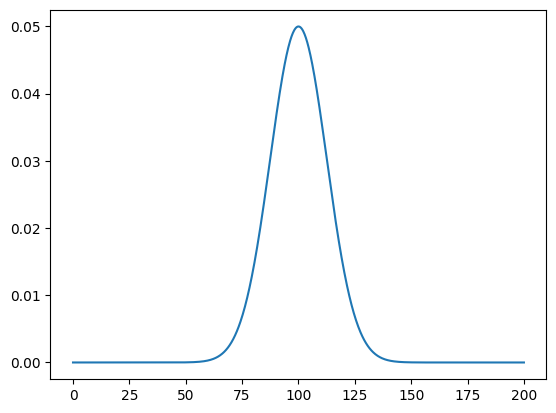

In [11]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Gaussian(tlist, {'A': 0.1}, 100))

### 2) Single $ \pi $ Pulse

In [12]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

In [13]:
# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

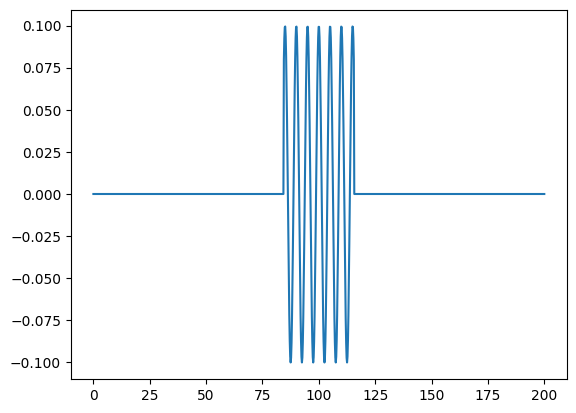

In [14]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(0, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.2, 'Phi': 0}, 100))

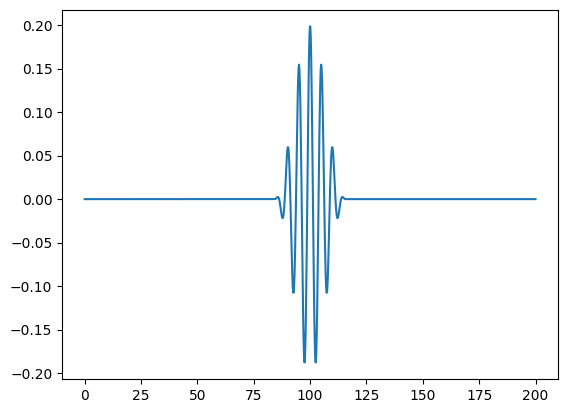

In [15]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(1, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.2, 'Phi': 0}, 100))

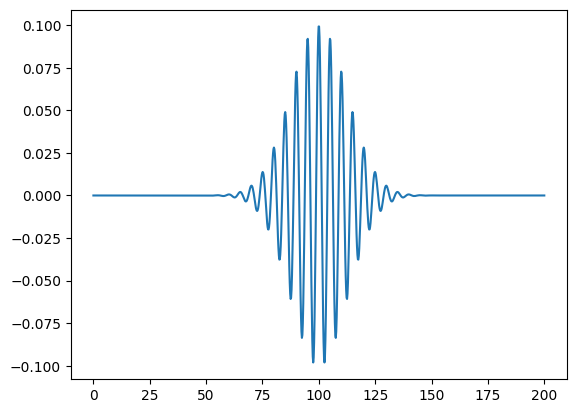

In [16]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(2, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.2, 'Phi': 0}, 100))

### 3) Pulse Shaping Function

In [17]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [18]:
Pulse_Timing(0, 200, 10, 0)

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190.])

In [19]:
Pulse_Timing(100, 300, 10, 2)

array([106.81483474, 119.9800845 , 138.59855926, 161.40144074,
       186.83475024, 213.16524976, 238.59855926, 261.40144074,
       280.0199155 , 293.18516526])

In [20]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)

    # CPMG & UDD
    else :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [21]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': A}, T_end)

    return pulse

### 1) T2 Measuring Function

In [151]:
def T2_Measure(A, N, Func):

  omega_q = 2 * np.pi * 6.0
  omega_rd = 2 * np.pi * 6.0
  gamma_phi = 2 * np.pi * 0.0001

  sz = sigmaz()
  sx = sigmax()
  sy = sigmay()

  H0 = -0.5*omega_q*sz

  op_list = [sx, sy, sz]
  col_list = [np.sqrt(gamma_phi/2) * sz]


  T_end_seq = [10*i for i in range(20,101,5)]
  Off_diagonal_seq = []


  for i in range(20,101,5):

    tlist = np.linspace(-6, 10*i-6, 10000)

    result = mesolve(
      [H0, [sx, Hrd_lab_frame]],
      basis(2,0),
      tlist,
      c_ops = col_list,
      args = {'A': A, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i, 'N': N, 'Env': 0, 'Func': Func},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    X = result.expect[0]
    Y = result.expect[1]
    Off_diagonal_seq.append(np.sqrt(X[-1]**2 + Y[-1]**2))


  return np.array(Off_diagonal_seq)

In [152]:
def func(t, C, T2):
    return C * np.exp(-t/T2)

### 5) CP T2 Measure

In [24]:
# T2 according to N from 0 to 10
CP_T2_list = []

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

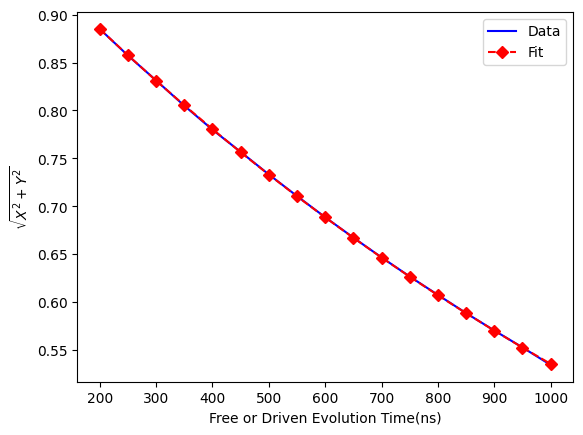

In [25]:
# N=0

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 0, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

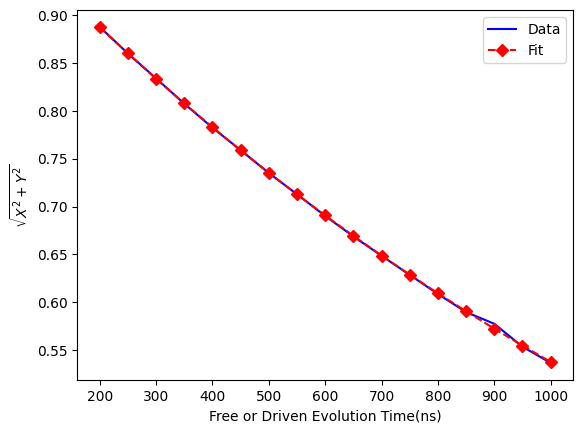

In [26]:
# N=1

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 1, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

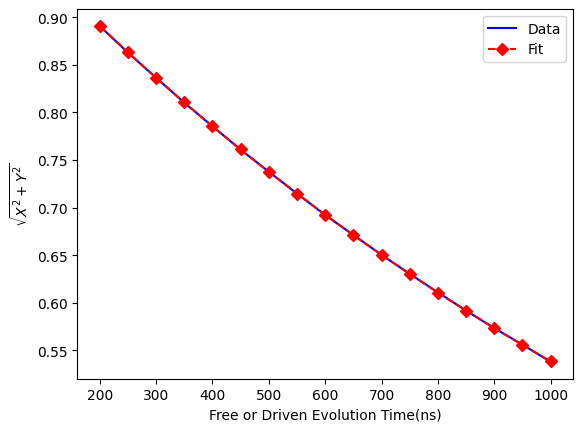

In [27]:
# N=2

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 2, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

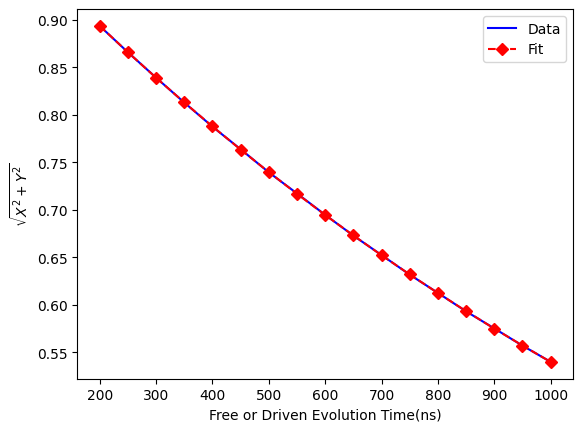

In [28]:
# N=3

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 3, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

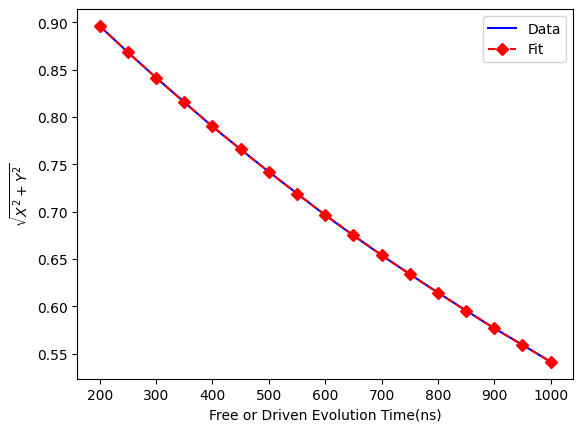

In [29]:
# N=4

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 4, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

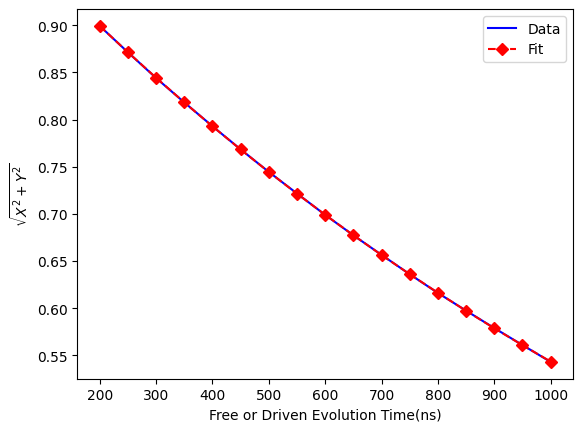

In [30]:
# N=5

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 5, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

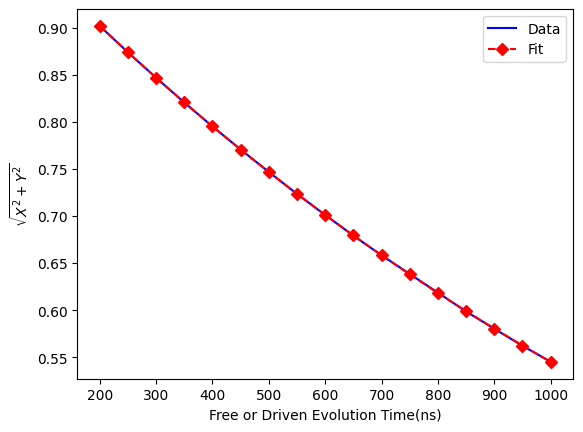

In [31]:
# N=6

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 6, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

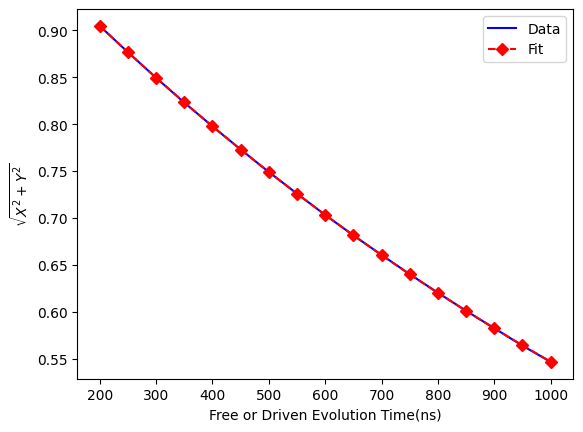

In [32]:
# N=7

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 7, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

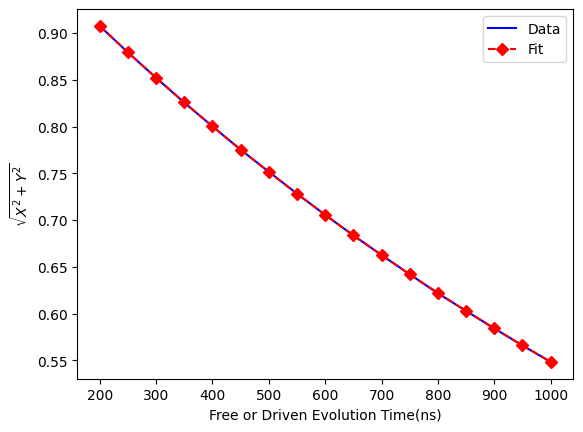

In [33]:
# N=8

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 8, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

In [44]:
CP_T2_list

[1591.241684570809,
 1596.1084094323742,
 1590.037044074392,
 1589.1135726232412,
 1589.8338126302078,
 1588.718835375871,
 1587.9918191448735,
 1588.550339791101,
 1588.4975927488595]

# 8. Pink Noise Decoupling

$H = -\frac{\omega_q+\delta\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

### 1) Pink Noise (Chap 5 Repeated)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [7]:
def Chi_Ensemble(mu, sigma, num_seq):

  X = np.random.normal(mu, sigma, num_seq)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [8]:
def Pink_Noise(args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  t_srt = args['t_srt']
  t_end = args['t_end']
  t_repeat = args['t_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A']

  tlist = np.linspace(t_srt, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]))

  arr = np.array(lst)

  return arr.sum(axis=0)

In [9]:
def func(t, b, a):
    return b + a * t

In [10]:
min_freq = 0.1
freq_repeat = 10000
t_repeat = 100000
t_srt = 0
t_end = 10

mu = 0
sigma = 1

A = 1

args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_srt': t_srt, 't_end': t_end, 't_repeat': t_repeat, 'mu': mu, 'sigma': sigma, 'A': A}

In [7]:
tlist = np.linspace(t_srt, t_end, t_repeat)
Pink_Noise_Sample = Pink_Noise(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise_Sample, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(undefined, 1d, C), int64, array(float64, 1d, C))':
   No match.

During: typing of setitem at <ipython-input-4-dc545b1bb285> (12)

File "<ipython-input-4-dc545b1bb285>", line 12:
def Pink_Noise(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A):
    <source elided>
  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]))
    ^


Text(0, 0.5, 'FT Absolute Value (linear scale)')

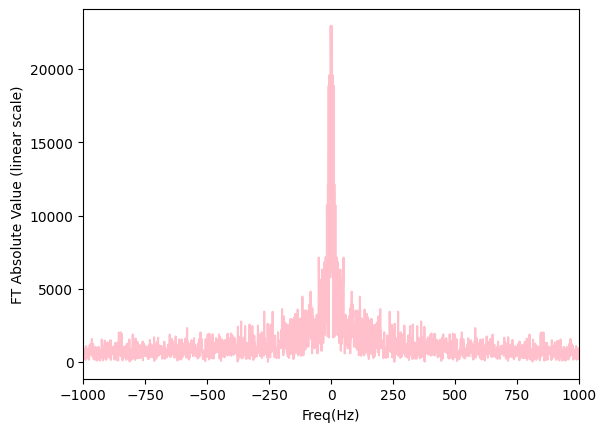

In [8]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft), label = 'Pink_Noise Distribution', color='pink')
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'FT Absolute Value (log scale)')

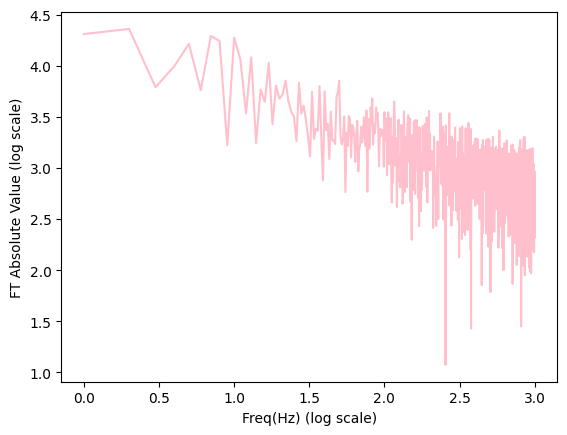

In [9]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog, label = 'Pink_Noise Distribution', color='pink')
plt.xlabel('Freq(Hz) (log scale)')
plt.ylabel('FT Absolute Value (log scale)')

[ 4.26991016 -0.51741745]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:625: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


Text(0, 0.5, 'FT Absolute Value (log scale)')

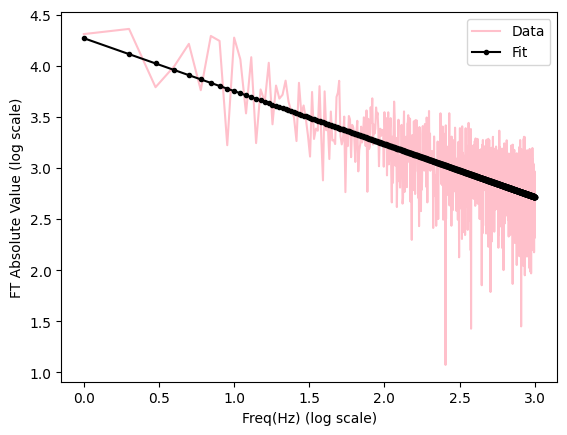

In [10]:
popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(Hz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

In [11]:
gamma_list = []

tau_end = 500
num = 1000


for tau in range(-500, 500, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + Pink_Noise_Sample[i]*Pink_Noise_Sample[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.05, 0.05, 1000)

Text(0, 0.5, 'Auto Correlation')

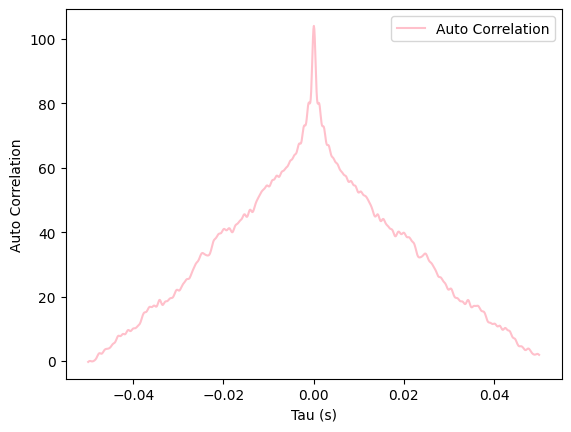

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value (linear scale)')

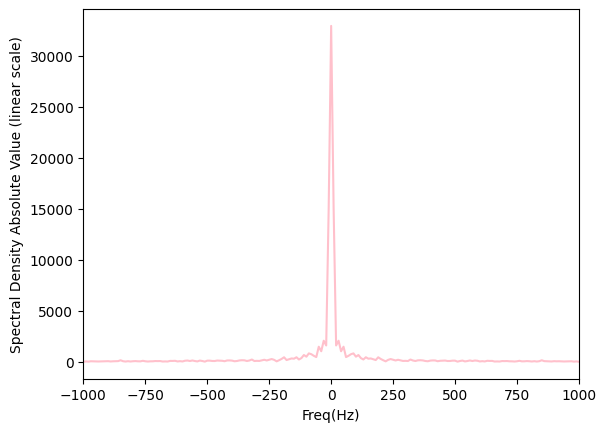

In [13]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft), label = 'Spectral Density', color='pink')
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (linear scale)')

Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

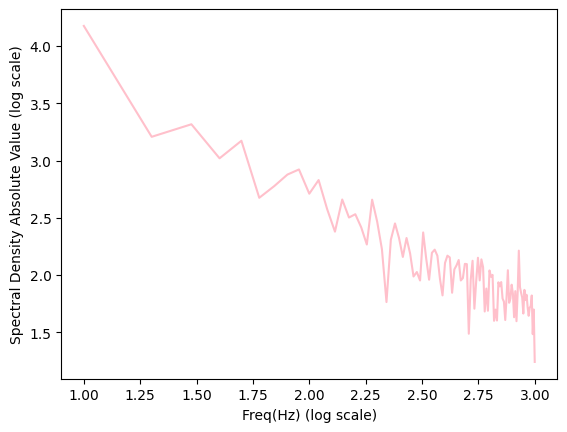

In [14]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

Gamma_freq_p = Gamma_freq[Gamma_freq > 0]
Gamma_fft_p = Gamma_fft[Gamma_freq > 0]

Gamma_freq_plog = np.log10(Gamma_freq_p[Gamma_freq_p < 1000])
Gamma_fft_plog = np.log10(Gamma_fft_p[Gamma_freq_p < 1000])

plt.figure()
plt.plot(Gamma_freq_plog, Gamma_fft_plog, color='pink')
plt.xlabel('Freq(Hz) (log scale)')
plt.ylabel('Spectral Density Absolute Value (log scale)')

[ 4.76925992 -1.03452201]


Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

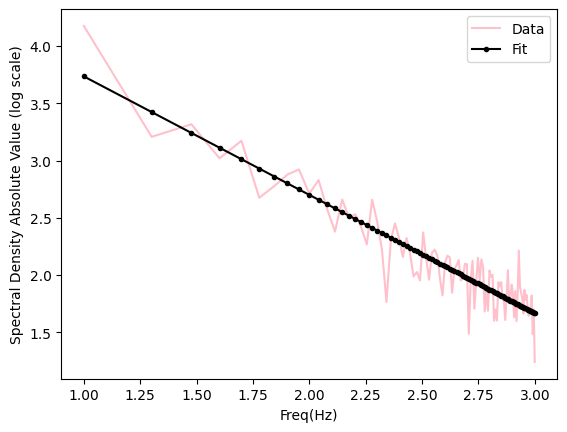

In [15]:
popt, pcov = curve_fit(func, Gamma_freq_plog, Gamma_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(Gamma_freq_plog, Gamma_fft_plog, label = 'Data', color='pink')
ax.plot(Gamma_freq_plog, func(Gamma_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(Hz)')
ax.set_ylabel('Spectral Density Absolute Value (log scale)')

### 2) White Noise (Chap 5 Repeated)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{1}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [21]:
def Chi_Ensemble(mu, sigma, num_seq):

  X = np.random.normal(mu, sigma, num_seq)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [22]:
def White_Noise(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A):

  tlist = np.linspace(t_srt, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]))

  arr = np.array(lst)

  return arr.sum(axis=0)

In [23]:
def func(t, b, a):
    return b + a * t

In [24]:
min_freq = 0.1
freq_repeat = 10000
t_repeat = 10000
t_srt = 0
t_end = 1

mu = 0
sigma = 0.01

A = 1

Text(0, 0.5, 'White_Noise Distribution')

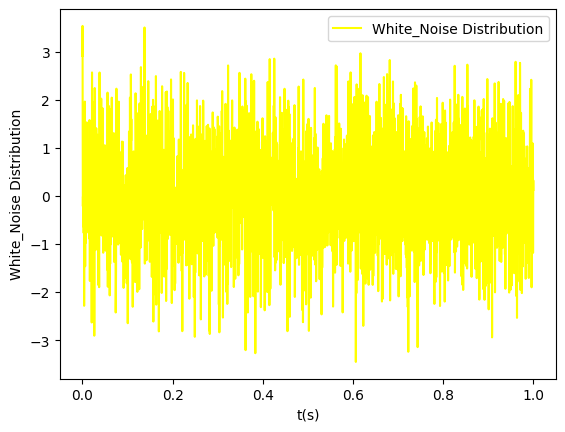

In [25]:
tlist = np.linspace(t_srt, t_end, t_repeat)
White_Noise_Sample = White_Noise(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, White_Noise_Sample, label = 'White_Noise Distribution', color='yellow')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('White_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

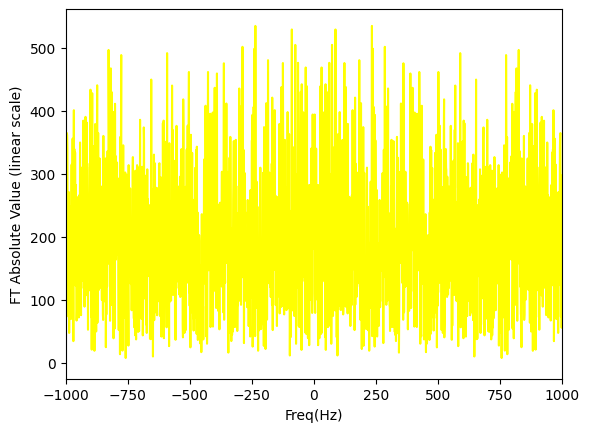

In [26]:
x_fft = np.fft.fftshift(np.fft.fft(White_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(White_Noise_Sample), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft), label = 'White_Noise Distribution', color='yellow')
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

Text(0, 0.5, 'FT Absolute Value (log scale)')

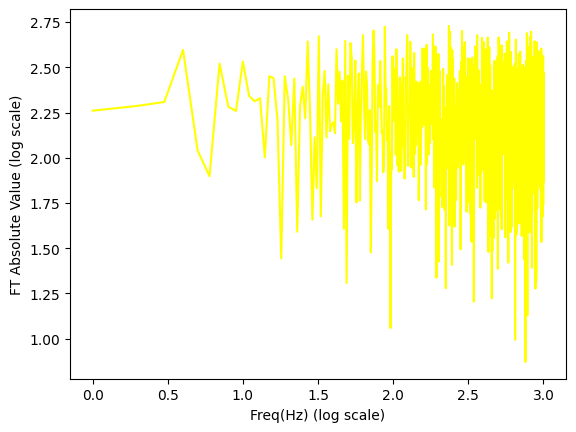

In [27]:
x_fft = np.fft.fftshift(np.fft.fft(White_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(White_Noise_Sample), d=tlist[1]-tlist[0]))

x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog, label = 'White_Noise Distribution', color='yellow')
plt.xlabel('Freq(Hz) (log scale)')
plt.ylabel('FT Absolute Value (log scale)')

[ 2.22910035 -0.00564375]


Text(0, 0.5, 'FT Absolute Value (log scale)')

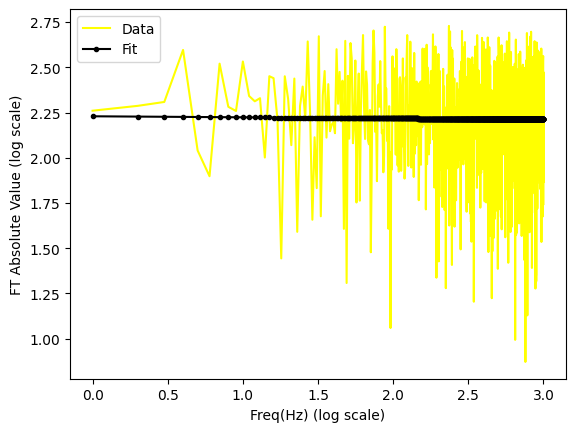

In [28]:
popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='yellow')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(Hz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

In [29]:
gamma_list = []

tau_end = 500
num = 1000


for tau in range(-500, 500, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + White_Noise_Sample[i]*White_Noise_Sample[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.05, 0.05, 1000)

Text(0, 0.5, 'Auto Correlation')

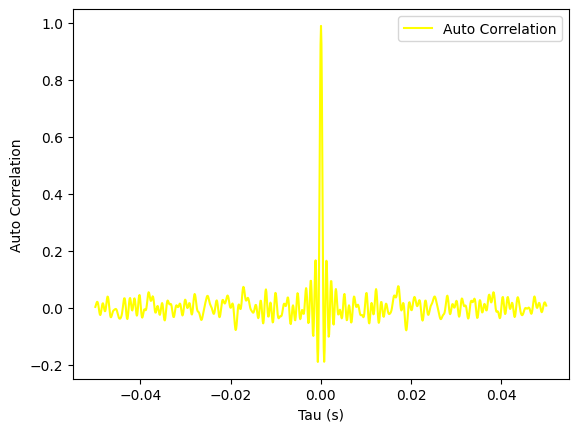

In [30]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation', color='yellow')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value (linear scale)')

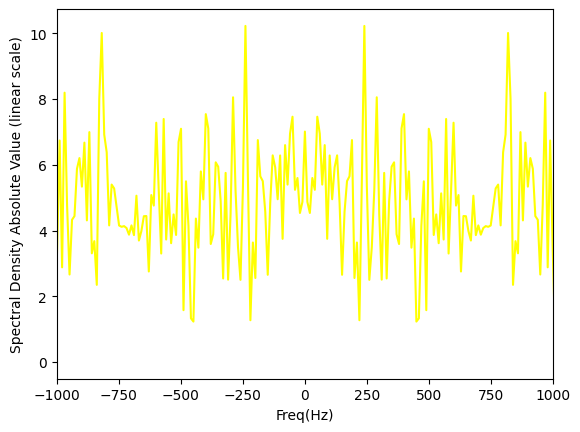

In [31]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft), label = 'Spectral Density', color='yellow')
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (linear scale)')

Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

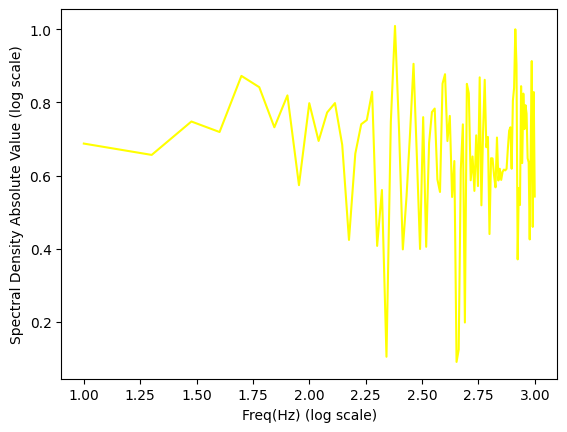

In [32]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

Gamma_freq_p = Gamma_freq[Gamma_freq > 0]
Gamma_fft_p = Gamma_fft[Gamma_freq > 0]

Gamma_freq_plog = np.log10(Gamma_freq_p[Gamma_freq_p < 1000])
Gamma_fft_plog = np.log10(Gamma_fft_p[Gamma_freq_p < 1000])

plt.figure()
plt.plot(Gamma_freq_plog, Gamma_fft_plog, color='yellow')
plt.xlabel('Freq(Hz) (log scale)')
plt.ylabel('Spectral Density Absolute Value (log scale)')

[ 0.75690424 -0.03715161]


Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

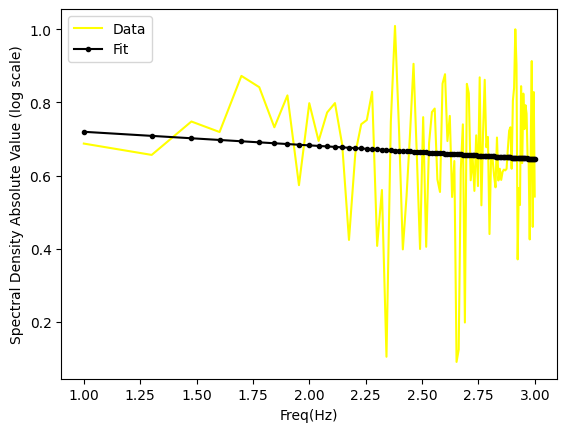

In [33]:
popt, pcov = curve_fit(func, Gamma_freq_plog, Gamma_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(Gamma_freq_plog, Gamma_fft_plog, label = 'Data', color='yellow')
ax.plot(Gamma_freq_plog, func(Gamma_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(Hz)')
ax.set_ylabel('Spectral Density Absolute Value (log scale)')

### 3) Noise Modularization & Trace Creation

Create 100 Noise Signal Traces

In [16]:
# must input t_repeat = 10000 * (t_end-t_srt)

def Pink_Noise_Interpolate(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A):

  tlist = np.linspace(t_srt, t_end, t_repeat)
  Pink_Noise_Discrete = np.array([])

  num = (int)((t_end-t_srt)/13)

  for i in range(num):
    Noise = Pink_Noise(min_freq, freq_repeat, 0, 13, 130000, mu, sigma, A)
    Pink_Noise_Discrete = np.concatenate((Pink_Noise_Discrete, Noise), axis=0)

  Pink_Noise_Continuous = scipy.interpolate.interp1d(tlist, Pink_Noise_Discrete, fill_value="extrapolate")
  return Pink_Noise_Continuous

In [ ]:
tlist = np.linspace(-10, 510, 5200000)
noise = Pink_Noise_Interpolate(0.1, 10000, -10, 510, 5200000, 0, 1, 1)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, noise(tlist), label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'Pink_Noise Distribution')

In [ ]:
x_fft = np.fft.fftshift(np.fft.fft(noise(tlist)))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(noise(tlist)), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft), label = 'Pink_Noise Distribution', color='pink')
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

In [ ]:
x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog, label = 'Pink_Noise Distribution', color='pink')
plt.xlabel('Freq(Hz) (log scale)')
plt.ylabel('FT Absolute Value (log scale)')

In [ ]:
popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(Hz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')